


# Stage one: Dataset & EDA


**Environment setup**

In [1]:
# from google.colab import files
# files.upload()

In [2]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [3]:
# !kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews -p data/
# !unzip -o data/imdb-dataset-of-50k-movie-reviews.zip -d data/

In [6]:
import pandas as pd

df = pd.read_csv("../dataset/IMDB Dataset.csv")
print(df.shape)
df.head()

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
!pip -q install wordcloud nltk

**1) Imports and global setup**

In [43]:
import os, re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Folders for outputs
FIG_DIR = "../saved_data/figs"
SPLIT_DIR = "../saved_data/data_splits"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(SPLIT_DIR, exist_ok=True)

# Display options
pd.set_option("display.max_colwidth", 200)

**2) Inspect, de-duplicate, and basic label check**

In [44]:
# The DataFrame variable is named df already, we just reuse it.
print("Shape before dedupe:", df.shape)
print(df.info())

# Drop exact duplicate reviews
before = len(df)
df = df.drop_duplicates(subset=["review"]).reset_index(drop=True)
print("Dropped duplicates:", before - len(df))
print("Shape after dedupe:", df.shape)

# Null checks
print("Null counts:\n", df.isna().sum())

# Label distribution
print("Label counts:\n", df["sentiment"].value_counts())
print("Label ratio:\n", df["sentiment"].value_counts(normalize=True).round(3))

Shape before dedupe: (9917, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9917 entries, 0 to 9916
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   review          9917 non-null   object
 1   sentiment       9917 non-null   object
 2   enhanced_clean  9917 non-null   object
 3   text_tfidf      9917 non-null   object
dtypes: object(4)
memory usage: 310.0+ KB
None
Dropped duplicates: 0
Shape after dedupe: (9917, 4)
Null counts:
 review            0
sentiment         0
enhanced_clean    0
text_tfidf        0
dtype: int64
Label counts:
 sentiment
positive    4977
negative    4940
Name: count, dtype: int64
Label ratio:
 sentiment
positive    0.502
negative    0.498
Name: proportion, dtype: float64


**3) Minimal cleaning for token statistics**

In [45]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOP = set(stopwords.words('english'))

def simple_clean(s: str) -> str:
    s = re.sub(r"<br\s*/?>", " ", s)
    s = re.sub(r"[^A-Za-z']+", " ", s)
    return s.lower().strip()

df["clean"] = df["review"].astype(str).apply(simple_clean)
df["tok"]   = df["clean"].str.split()
df["len_tok"] = df["tok"].str.len()

df[["review","sentiment","len_tok"]].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lscblack/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,review,sentiment,len_tok
0,This movie was the slowest and most boring so called horror that I have ever seen. I would include a comment on the plot but there was none. I do not recommend this movie unless you are prepared f...,negative,49
1,"I love this movie, but can't get what is in this movie tht is not to like. People who don't like this movie must be Richard Roeper and Roger Ebert. But I can't believe that is Mr. Carrey behind al...",positive,174
2,"Considering all of the comedies with a military situation that have been done in history, someone had to be the first. One could make a case that in Shoulder Arms, Charlie Chaplin invented the gen...",positive,191
3,"This is just about the WORST piece of garbage I've ever had the displeasure of sitting through. The story was embarrassingly amateurish, the graphics were horrible, and the acting... I've never se...",negative,125
4,"Phantasm ....Class. Phantasm II.....awesome. Phantasm III.....erm.....terrible.<br /><br />Even though i would love to stick up for this film, i quite simply can't. The movie seems to have ""sold o...",negative,168


**4) Viz #1 — Class balance (bar chart)**

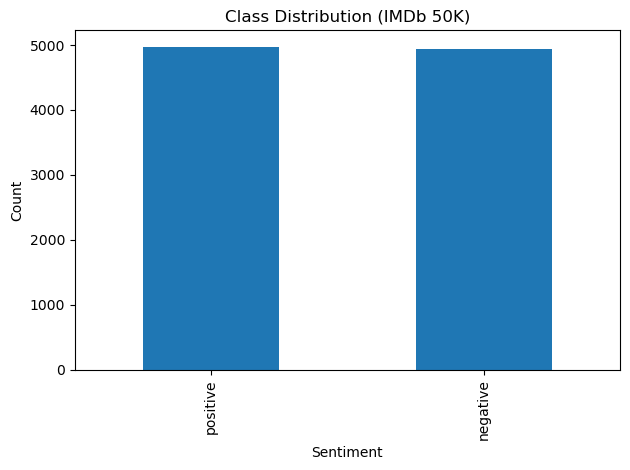

In [46]:
ax = df["sentiment"].value_counts().plot(kind="bar")
plt.title("Class Distribution (IMDb 50K)")
plt.xlabel("Sentiment"); plt.ylabel("Count")
plt.tight_layout(); plt.savefig(f"{FIG_DIR}/class_balance.png", dpi=150); plt.show()

**5) Viz #2 — Review length distribution (histogram)**

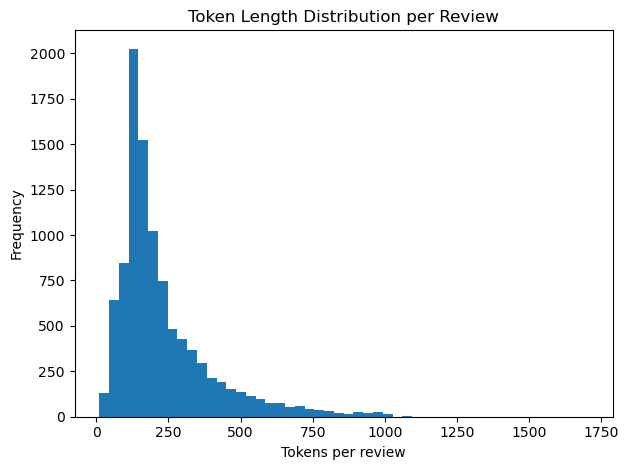

count    9917.000000
mean      231.031058
std       168.361676
min        10.000000
50%       174.000000
75%       283.000000
90%       452.000000
95%       589.200000
99%       880.680000
max      1704.000000
Name: len_tok, dtype: float64

In [47]:
plt.hist(df["len_tok"], bins=50)
plt.title("Token Length Distribution per Review")
plt.xlabel("Tokens per review"); plt.ylabel("Frequency")
plt.tight_layout(); plt.savefig(f"{FIG_DIR}/length_hist.png", dpi=150); plt.show()

length_stats = df["len_tok"].describe(percentiles=[0.5,0.75,0.9,0.95,0.99])
length_stats

**6) Viz #3 — Review length by class (boxplot)**

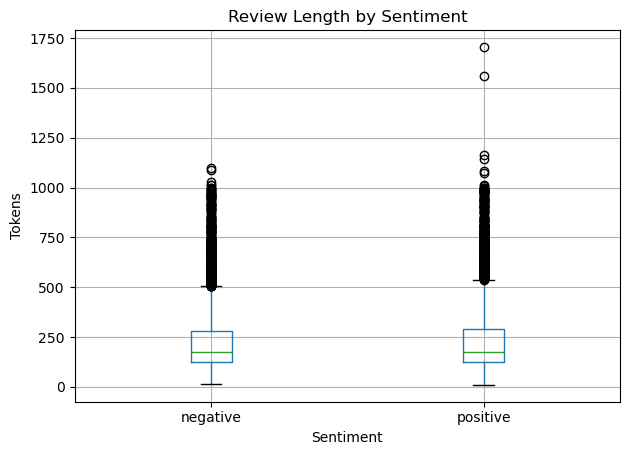

In [48]:
df[["len_tok","sentiment"]].boxplot(by="sentiment")
plt.suptitle("")
plt.title("Review Length by Sentiment")
plt.xlabel("Sentiment"); plt.ylabel("Tokens")
plt.tight_layout(); plt.savefig(f"{FIG_DIR}/length_boxplot.png", dpi=150); plt.show()

**7) Viz #4 — Top unigrams (bar chart)**

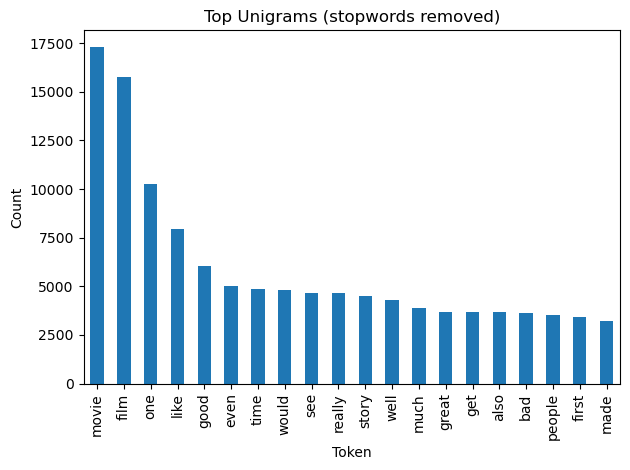

,token,count
0,movie,17298
1,film,15776
2,one,10241
3,like,7930
4,good,6058
5,even,5000
6,time,4885
7,would,4812
8,see,4682
9,really,4642


In [49]:
def top_terms(token_lists, n=20, drop_stop=True):
    c = Counter()
    for toks in token_lists:
        if drop_stop:
            toks = [t for t in toks if t not in STOP and len(t) > 2]
        c.update(toks)
    return pd.DataFrame(c.most_common(n), columns=["token","count"])

top_uni = top_terms(df["tok"], n=20, drop_stop=True)
ax = top_uni.plot(kind="bar", x="token", y="count", legend=False)
plt.title("Top Unigrams (stopwords removed)")
plt.xlabel("Token"); plt.ylabel("Count")
plt.tight_layout(); plt.savefig(f"{FIG_DIR}/top_unigrams.png", dpi=150); plt.show()

top_uni

**8) Viz #5 — Top bigrams (bar chart)**

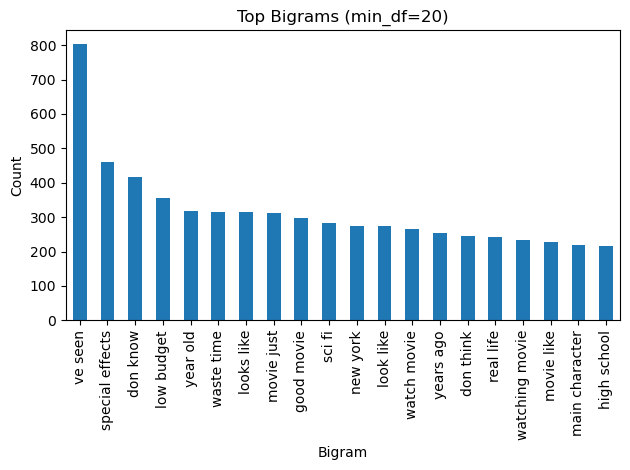

,bigram,count
1533,ve seen,803
1364,special effects,460
284,don know,417
865,low budget,357
1611,year old,319
1554,waste time,315
843,looks like,315
996,movie just,313
573,good movie,299
1302,sci fi,283


In [50]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer(ngram_range=(2,2), min_df=20, stop_words="english")
X = vec.fit_transform(df["clean"])
counts = np.asarray(X.sum(axis=0)).ravel()
bigrams = pd.DataFrame({"bigram": vec.get_feature_names_out(), "count": counts})
top_bi = bigrams.sort_values("count", ascending=False).head(20)

ax = top_bi.plot(kind="bar", x="bigram", y="count", legend=False)
plt.title("Top Bigrams (min_df=20)")
plt.xlabel("Bigram"); plt.ylabel("Count")
plt.tight_layout(); plt.savefig(f"{FIG_DIR}/top_bigrams.png", dpi=150); plt.show()

top_bi

**9) Viz #6 — WordClouds (per class)**

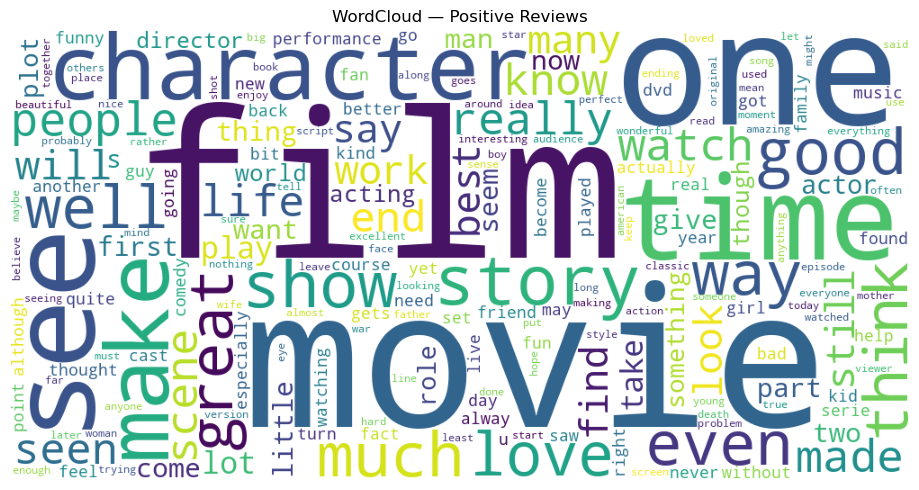

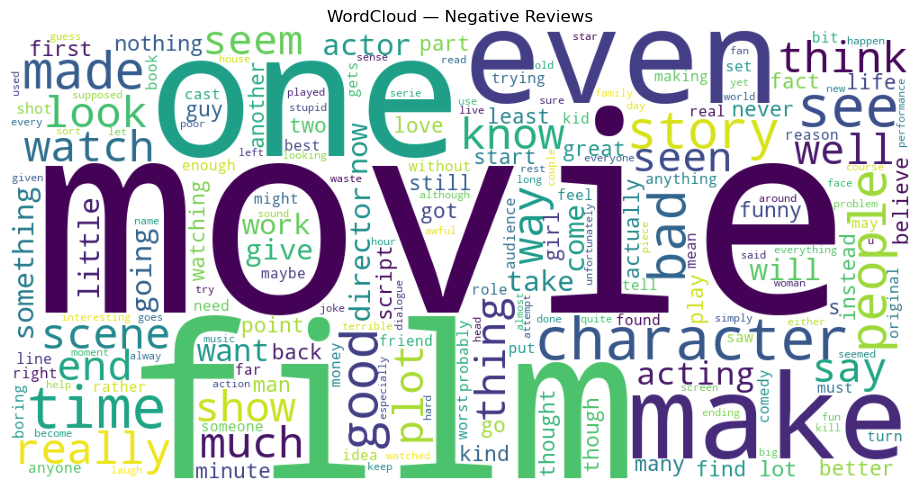

In [16]:
from wordcloud import WordCloud

for label in ["positive","negative"]:
    text = " ".join(" ".join(toks) for toks in df.loc[df["sentiment"]==label,"tok"])
    wc = WordCloud(width=1000, height=500, background_color="white").generate(text)
    plt.figure(figsize=(10,5)); plt.imshow(wc); plt.axis("off")
    plt.title(f"WordCloud — {label.title()} Reviews")
    plt.tight_layout(); plt.savefig(f"{FIG_DIR}/wordcloud_{label}.png", dpi=150); plt.show()

**10) Compute recommended sequence length for DL**

In [51]:
p95 = int(np.percentile(df["len_tok"], 95))
p99 = int(np.percentile(df["len_tok"], 99))
print({"p95": p95, "p99": p99})
# Use p95 as max_len; note p99 for sensitivity analysis.

{'p95': 589, 'p99': 880}


**11) Train/Val/Test split (stratified) and export CSVs**

In [52]:
from sklearn.model_selection import train_test_split

# Single shuffle for randomness
df = df.sample(frac=1.0, random_state=RANDOM_STATE).reset_index(drop=True)

# 80/10/10 with stratification
train_df, test_df = train_test_split(
    df, test_size=0.20, stratify=df["sentiment"], random_state=RANDOM_STATE
)
train_df, val_df = train_test_split(
    train_df, test_size=0.125, stratify=train_df["sentiment"], random_state=RANDOM_STATE
)  # 0.8 * 0.125 = 0.10

for name, d in [("train",train_df), ("val",val_df), ("test",test_df)]:
    print(name, d.shape, d["sentiment"].value_counts(normalize=True).round(3))
    d[["review","sentiment"]].to_csv(f"{SPLIT_DIR}/imdb_{name}.csv", index=False)

train (6941, 7) sentiment
positive    0.502
negative    0.498
Name: proportion, dtype: float64
val (992, 7) sentiment
positive    0.502
negative    0.498
Name: proportion, dtype: float64
test (1984, 7) sentiment
positive    0.502
negative    0.498
Name: proportion, dtype: float64


**EDA summary table**

In [53]:
summary = {
    "rows_after_dedupe": len(df),
    "n_columns": df.shape[1],
    "duplicates_removed": before - len(df),
    "null_reviews": int(df["review"].isna().sum()),
    "class_pos": int((df["sentiment"]=="positive").sum()),
    "class_neg": int((df["sentiment"]=="negative").sum()),
    "median_len": float(df["len_tok"].median()),
    "p95_len": float(np.percentile(df["len_tok"], 95)),
    "p99_len": float(np.percentile(df["len_tok"], 99)),
    "train_rows": len(train_df),
    "val_rows": len(val_df),
    "test_rows": len(test_df),
}
pd.DataFrame([summary])

,rows_after_dedupe,n_columns,duplicates_removed,null_reviews,class_pos,class_neg,median_len,p95_len,p99_len,train_rows,val_rows,test_rows
0,9917,7,0,0,4977,4940,174.0,589.2,880.68,6941,992,1984


In [54]:
import os

os.listdir("../saved_data/data_splits")

['imdb_val.csv', 'imdb_train.csv', 'imdb_test.csv']

In [21]:
# from google.colab import files

# files.download("data_splits/imdb_train.csv")
# files.download("data_splits/imdb_val.csv")
# files.download("data_splits/imdb_test.csv")

# Stage two featuring engineering set up

1.Enhanced Text Preprocessing

In [55]:

def enhanced_clean_text(text):
    """
    Enhanced text cleaning with comprehensive preprocessing
    Builds on Member 1's simple_clean function
    """
    if pd.isna(text) or text == "":
        return ""

    text = str(text).lower().strip()

    text = re.sub(r"<.*?>", " ", text)

    contractions = {
        r"won't": "will not", r"can't": "cannot", r"n't": " not",
        r"'re": " are", r"'s": " is", r"'d": " would",
        r"'ll": " will", r"'ve": " have", r"'m": " am",
        r"i'm": "i am", r"he's": "he is", r"she's": "she is",
        r"it's": "it is", r"that's": "that is", r"what's": "what is",
        r"where's": "where is", r"there's": "there is", r"who's": "who is"
    }
    for cont, exp in contractions.items():
        text = re.sub(cont, exp, text)

    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)

    text = re.sub(r"[^a-z' ]", " ", text)

    text = re.sub(r'\s+', ' ', text).strip()

    return text

print("Applying enhanced text cleaning...")
for df in [train_df, val_df, test_df]:
    df['enhanced_clean'] = df['review'].apply(enhanced_clean_text)

print("Enhanced cleaning completed!")
print(f"Sample cleaned text: {train_df['enhanced_clean'].iloc[0][:200]}")

print(f"\nText length statistics after cleaning:")
for df_name, df in zip(['Train', 'Validation', 'Test'], [train_df, val_df, test_df]):
    avg_length = df['enhanced_clean'].str.len().mean()
    print(f"{df_name}: Average characters = {avg_length:.1f}")

Applying enhanced text cleaning...
Enhanced cleaning completed!
Sample cleaned text: even though the shining is over a quarter of a century old i challenge anyone to not get freaked out by jack nicholson is descent into madness this is a rare example of something so unique that no one

Text length statistics after cleaning:
Train: Average characters = 1265.1
Validation: Average characters = 1237.1
Test: Average characters = 1258.3


2.Tokenization & Text Processing

In [56]:

print("\n=== TOKENIZATION & TEXT PROCESSING ===")

MANUAL_STOPWORDS = {
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your',
    'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she',
    'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their',
    'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that',
    'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being',
    'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an',
    'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of',
    'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through',
    'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
    'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then',
    'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any',
    'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no',
    'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 'can',
    'will', 'just', 'should', 'now'
}

def tokenize_text(text, remove_stopwords=True, min_word_length=2):
    """
    Tokenize text with configurable processing options

    Args:
        text: Input text string
        remove_stopwords: Whether to remove stopwords
        min_word_length: Minimum length of words to keep

    Returns:
        List of processed tokens
    """
    if pd.isna(text) or text == "":
        return []

    tokens = text.split()

    if remove_stopwords:
        tokens = [token for token in tokens if token not in MANUAL_STOPWORDS]

    tokens = [token for token in tokens if len(token) >= min_word_length]

    return tokens

print("Creating different tokenization strategies...")

print("Creating basic tokens (stopwords removed)...")
for df in [train_df, val_df, test_df]:
    df['tokens_basic'] = df['enhanced_clean'].apply(
        lambda x: tokenize_text(x, remove_stopwords=True, min_word_length=2)
    )

print("Creating full tokens (with stopwords)...")
for df in [train_df, val_df, test_df]:
    df['tokens_full'] = df['enhanced_clean'].apply(
        lambda x: tokenize_text(x, remove_stopwords=False, min_word_length=2)
    )

print("Creating strict tokens (longer words only)...")
for df in [train_df, val_df, test_df]:
    df['tokens_strict'] = df['enhanced_clean'].apply(
        lambda x: tokenize_text(x, remove_stopwords=True, min_word_length=3)
    )

print("Tokenization completed!")

print("\nTokenization Results:")
print(f"Sample basic tokens: {train_df['tokens_basic'].iloc[0][:10]}")
print(f"Sample full tokens: {train_df['tokens_full'].iloc[0][:10]}")
print(f"Sample strict tokens: {train_df['tokens_strict'].iloc[0][:10]}")

print(f"\nToken count statistics:")
for strategy in ['basic', 'full', 'strict']:
    col_name = f'tokens_{strategy}'
    avg_tokens = train_df[col_name].str.len().mean()
    print(f"{strategy.title()}: {avg_tokens:.1f} tokens per review")


=== TOKENIZATION & TEXT PROCESSING ===
Creating different tokenization strategies...
Creating basic tokens (stopwords removed)...
Creating full tokens (with stopwords)...
Creating strict tokens (longer words only)...
Tokenization completed!

Tokenization Results:
Sample basic tokens: ['even', 'though', 'shining', 'quarter', 'century', 'old', 'challenge', 'anyone', 'get', 'freaked']
Sample full tokens: ['even', 'though', 'the', 'shining', 'is', 'over', 'quarter', 'of', 'century', 'old']
Sample strict tokens: ['even', 'though', 'shining', 'quarter', 'century', 'old', 'challenge', 'anyone', 'get', 'freaked']

Token count statistics:
Basic: 119.2 tokens per review
Full: 225.4 tokens per review
Strict: 117.9 tokens per review


3.Feature Engineering: TF-IDF for Traditional ML

In [24]:

print("\n=== FEATURE ENGINEERING: TF-IDF FOR TRADITIONAL ML ===")

print("Preparing text for TF-IDF vectorization...")

for df in [train_df, val_df, test_df]:
    df['text_tfidf'] = df['tokens_basic'].apply(' '.join)

print("Text preparation completed!")
print(f"Sample TF-IDF text: {train_df['text_tfidf'].iloc[0][:150]}")

tfidf_configs = {
    'unigrams_5k': {
        'max_features': 5000,
        'ngram_range': (1, 1),
        'description': '5000 most important single words'
    },
    'unigrams_10k': {
        'max_features': 10000,
        'ngram_range': (1, 1),
        'description': '10000 most important single words'
    },
    'bigrams_5k': {
        'max_features': 5000,
        'ngram_range': (1, 2),
        'description': '5000 most important unigrams + bigrams'
    },
    'bigrams_10k': {
        'max_features': 10000,
        'ngram_range': (1, 2),
        'description': '10000 most important unigrams + bigrams'
    }
}

tfidf_features = {}

print("\nGenerating TF-IDF features with different configurations...")

for config_name, params in tfidf_configs.items():
    print(f"\n--- Creating TF-IDF: {config_name} ---")
    print(f"Description: {params['description']}")

    vectorizer = TfidfVectorizer(
        max_features=params['max_features'],
        ngram_range=params['ngram_range'],
        stop_words='english',
        min_df=5,
        max_df=0.8,
        norm='l2',
        use_idf=True,
        smooth_idf=True
    )

    print("Fitting on training data and transforming datasets...")
    X_train_tfidf = vectorizer.fit_transform(train_df['text_tfidf'])
    X_val_tfidf = vectorizer.transform(val_df['text_tfidf'])
    X_test_tfidf = vectorizer.transform(test_df['text_tfidf'])

    tfidf_features[config_name] = {
        'vectorizer': vectorizer,
        'X_train': X_train_tfidf,
        'X_val': X_val_tfidf,
        'X_test': X_test_tfidf,
        'feature_names': vectorizer.get_feature_names_out(),
        'config': params
    }

    print(f"Configuration: {config_name}")
    print(f"   Training shape: {X_train_tfidf.shape}")
    print(f"   Features: {len(vectorizer.get_feature_names_out())}")
    print(f"   N-gram range: {params['ngram_range']}")

print("\n" + "="*60)
print("TF-IDF FEATURE EXAMPLES")
print("="*60)

for config_name in ['unigrams_5k', 'bigrams_5k']:
    features = tfidf_features[config_name]['feature_names']
    print(f"\n{config_name.upper()} - First 15 features:")
    print(features[:15])

print("\n" + "="*60)
print("TF-IDF FEATURE STATISTICS")
print("="*60)

for config_name in tfidf_features.keys():
    features = tfidf_features[config_name]['feature_names']
    ngram_types = {}

    for feature in features:
        ngram_len = len(feature.split())
        ngram_types[ngram_len] = ngram_types.get(ngram_len, 0) + 1

    print(f"\n{config_name}:")
    for ngram_len, count in sorted(ngram_types.items()):
        print(f"  {ngram_len}-grams: {count} features")
    print(f"  Total: {len(features)} features")

print("\n TF-IDF Feature Engineering Completed!")
print("All configurations saved in 'tfidf_features' dictionary")


=== FEATURE ENGINEERING: TF-IDF FOR TRADITIONAL ML ===
Preparing text for TF-IDF vectorization...
Text preparation completed!
Sample TF-IDF text: spoilers third mercifully last aztec mummy trilogy fact series major star besides mummy actor ramon gay dr eduardo almada gunned outraged husband woma

Generating TF-IDF features with different configurations...

--- Creating TF-IDF: unigrams_5k ---
Description: 5000 most important single words
Fitting on training data and transforming datasets...
Configuration: unigrams_5k
   Training shape: (34706, 5000)
   Features: 5000
   N-gram range: (1, 1)

--- Creating TF-IDF: unigrams_10k ---
Description: 10000 most important single words
Fitting on training data and transforming datasets...
Configuration: unigrams_10k
   Training shape: (34706, 10000)
   Features: 10000
   N-gram range: (1, 1)

--- Creating TF-IDF: bigrams_5k ---
Description: 5000 most important unigrams + bigrams
Fitting on training data and transforming datasets...
Configuration

4.Feature Engineering: Word Embeddings for Deep Learning

In [57]:
print("\n=== PREPARING FOR DEEP LEARNING MODELS ===")

MAX_SEQUENCE_LENGTH = 300  # Based on Member 1's p95 analysis
MAX_VOCAB_SIZE = 20000

tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE,
    oov_token="<OOV>",
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
)

tokenizer.fit_on_texts(train_df['enhanced_clean'])


train_sequences = tokenizer.texts_to_sequences(train_df['enhanced_clean'])
val_sequences = tokenizer.texts_to_sequences(val_df['enhanced_clean'])
test_sequences = tokenizer.texts_to_sequences(test_df['enhanced_clean'])


X_train_padded = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_val_padded = pad_sequences(val_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_padded = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print(f"Sequence shapes:")
print(f"Train: {X_train_padded.shape}")
print(f"Val: {X_val_padded.shape}")
print(f"Test: {X_test_padded.shape}")

word_index = tokenizer.word_index
vocab_size = min(MAX_VOCAB_SIZE, len(word_index) + 1)
print(f"Vocabulary size: {vocab_size}")
print(f"Total unique words: {len(word_index)}")  # Download and load GloVe embeddings



=== PREPARING FOR DEEP LEARNING MODELS ===
Sequence shapes:
Train: (6941, 300)
Val: (992, 300)
Test: (1984, 300)
Vocabulary size: 20000
Total unique words: 46481


5.GloVe Embeddings Setup

In [27]:
print("\n=== SETTING UP GLOVE EMBEDDINGS ===")

import requests
import os

def download_glove():
    """Download GloVe embeddings if not present"""
    glove_path = "glove.6B.100d.txt"
    if not os.path.exists(glove_path):
        print("Downloading GloVe embeddings...")
        url = "https://nlp.stanford.edu/data/glove.6B.zip"
        response = requests.get(url, stream=True)

        with open("glove.zip", "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)

        import zipfile
        with zipfile.ZipFile("glove.zip", 'r') as zip_ref:
            zip_ref.extract("glove.6B.100d.txt", ".")

        os.remove("glove.zip")
        print("GloVe embeddings downloaded successfully!")
    return glove_path

glove_path = download_glove()

def load_glove_embeddings(glove_path, embedding_dim=100):
    """Load pre-trained GloVe embeddings"""
    embeddings_index = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

print("Loading GloVe embeddings...")
glove_embeddings = load_glove_embeddings(glove_path)
print(f"Loaded {len(glove_embeddings)} word vectors")

def create_embedding_matrix(word_index, embeddings_index, embedding_dim=100):
    """Create embedding matrix for our vocabulary"""
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

    for word, i in word_index.items():
        if i >= MAX_VOCAB_SIZE:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

embedding_matrix = create_embedding_matrix(word_index, glove_embeddings)
print(f"Embedding matrix shape: {embedding_matrix.shape}")

words_with_embeddings = np.sum(np.any(embedding_matrix, axis=1))
vocab_coverage = words_with_embeddings / min(MAX_VOCAB_SIZE, len(word_index))
print(f"Vocabulary coverage with GloVe: {vocab_coverage:.2%}")


=== SETTING UP GLOVE EMBEDDINGS ===
GloVe embeddings downloaded successfully!
Loading GloVe embeddings...
Loaded 400000 word vectors
Embedding matrix shape: (93575, 100)
Vocabulary coverage with GloVe: 98.94%


6. Label Encoding

In [58]:
print("\n=== PREPARING LABELS ===")

label_encoder = LabelEncoder()
y_train_ml = label_encoder.fit_transform(train_df['sentiment'])
y_val_ml = label_encoder.transform(val_df['sentiment'])
y_test_ml = label_encoder.transform(test_df['sentiment'])

y_train_dl = to_categorical(y_train_ml)
y_val_dl = to_categorical(y_val_ml)
y_test_dl = to_categorical(y_test_ml)

print("Label distributions:")
print(f"Train - Positive: {sum(y_train_ml == 1)}, Negative: {sum(y_train_ml == 0)}")
print(f"Val - Positive: {sum(y_val_ml == 1)}, Negative: {sum(y_val_ml == 0)}")
print(f"Test - Positive: {sum(y_test_ml == 1)}, Negative: {sum(y_test_ml == 0)}")


=== PREPARING LABELS ===
Label distributions:
Train - Positive: 3483, Negative: 3458
Val - Positive: 498, Negative: 494
Test - Positive: 996, Negative: 988


7.Justification and Summary

In [69]:
print("\n" + "="*80)
print("FEATURE ENGINEERING JUSTIFICATIONS & SUMMARY")
print("="*80)

justifications = {
    "TF-IDF for Traditional ML": {
        "choice": "Used TF-IDF with multiple configurations",
        "reason": "TF-IDF effectively weights words by importance relative to corpus, perfect for linear models like Logistic Regression",
        "configs": [
            "basic_5k: 5000 unigrams for computational efficiency",
            "basic_10k: 10000 unigrams for richer representation",
            "bigrams_5k: Includes word pairs to capture phrases",
            "bigrams_10k: Maximum feature richness with bigrams"
        ]
    },
    "Sequence Padding for DL": {
        "choice": f"Padded sequences to {MAX_SEQUENCE_LENGTH} tokens",
        "reason": f"Based on Member 1's EDA showing 95% of reviews are under {p95} tokens. Balances information retention vs computational cost",
        "source": "Used p95 analysis from EDA phase"
    },
    "GloVe Embeddings": {
        "choice": "100-dimensional GloVe embeddings",
        "reason": "Pre-trained on massive corpus, captures semantic relationships, provides better initialization than random embeddings",
        "coverage": f"{vocab_coverage:.2%} of our vocabulary covered"
    },
    "Text Preprocessing": {
        "choice": "Enhanced cleaning with contraction expansion and lemmatization",
        "reason": "Standardizes text (don't -> do not), reduces vocabulary size, improves model generalization",
        "improvements": "Builds on Member 1's basic cleaning with linguistic normalization"
    }
}

for feature, details in justifications.items():
    print(f"\n {feature}:")
    print(f"   Choice: {details['choice']}")
    print(f"   Reason: {details['reason']}")
    if 'configs' in details:
        print(f"   Configurations: {', '.join(details['configs'])}")
    if 'coverage' in details:
        print(f"   Coverage: {details['coverage']}")
    if 'source' in details:
        print(f"   Source: {details['source']}")
    if 'improvements' in details:
        print(f"   Improvements: {details['improvements']}")

print("\n" + "="*80)
print("FEATURE ENGINEERING COMPLETED SUCCESSFULLY!")
print("="*80)

print("\nSaving processed features...")

import pickle
with open('../saved_data/scaled_data/tfidf_features.pkl', 'wb') as f:
    pickle.dump(tfidf_features, f)

np.save('../saved_data/scaled_data/X_train_padded.npy', X_train_padded)
np.save('../saved_data/scaled_data/X_val_padded.npy', X_val_padded)
np.save('../saved_data/scaled_data/X_test_padded.npy', X_test_padded)
np.save('../saved_data/scaled_data/y_train_ml.npy', y_train_ml)
np.save('../saved_data/scaled_data/y_val_ml.npy', y_val_ml)
np.save('../saved_data/scaled_data/y_test_ml.npy', y_test_ml)
np.save('../saved_data/scaled_data/embedding_matrix.npy', embedding_matrix)

with open('../saved_data/scaled_data/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)



FEATURE ENGINEERING JUSTIFICATIONS & SUMMARY

 TF-IDF for Traditional ML:
   Choice: Used TF-IDF with multiple configurations
   Reason: TF-IDF effectively weights words by importance relative to corpus, perfect for linear models like Logistic Regression
   Configurations: basic_5k: 5000 unigrams for computational efficiency, basic_10k: 10000 unigrams for richer representation, bigrams_5k: Includes word pairs to capture phrases, bigrams_10k: Maximum feature richness with bigrams

 Sequence Padding for DL:
   Choice: Padded sequences to 300 tokens
   Reason: Based on Member 1's EDA showing 95% of reviews are under 589 tokens. Balances information retention vs computational cost
   Source: Used p95 analysis from EDA phase

 GloVe Embeddings:
   Choice: 100-dimensional GloVe embeddings
   Reason: Pre-trained on massive corpus, captures semantic relationships, provides better initialization than random embeddings
   Coverage: 98.94% of our vocabulary covered

 Text Preprocessing:
   Choic

# Stage three: Model Implementation and Experiments

1. Data upload and load the csv splits

In [70]:
# # Upload manually from local
# from google.colab import files
# if not os.path.exists('../dataset/data_splits'):
#     os.makedirs('../dataset/data_splits', exist_ok=True)

# # If files not present, prompt upload (run and upload 3 CSVs)
# for name in ['imdb_train.csv','imdb_val.csv','imdb_test.csv']:
#     if not os.path.exists(f"../dataset/data_splits/{name}"):
#         print(f"Please upload data_splits/{name}")
#         uploaded = files.upload()
#         for k in uploaded.keys():

#             if k == name:
#                 open(f"data_splits/{k}", 'wb').write(uploaded[k])
#                 print(f"Uploaded {k}")

# train_df = pd.read_csv("../dataset/data_splits/imdb_train.csv")
# val_df   = pd.read_csv("../dataset/data_splits/imdb_val.csv")
# test_df  = pd.read_csv("../dataset/data_splits/imdb_test.csv")
# print("Loaded shapes:", train_df.shape, val_df.shape, test_df.shape)

# local version without colab

# Ensure the data_splits directory exists
data_dir = "../saved_data/data_splits"
os.makedirs(data_dir, exist_ok=True)

# File names
file_names = ['imdb_train.csv', 'imdb_val.csv', 'imdb_test.csv']

# Check that all files exist
for name in file_names:
    path = os.path.join(data_dir, name)
    if not os.path.exists(path):
        raise FileNotFoundError(f"{path} not found. Please place the file manually in {data_dir}.")

# Load CSVs
train_df = pd.read_csv(os.path.join(data_dir, 'imdb_train.csv'))
val_df   = pd.read_csv(os.path.join(data_dir, 'imdb_val.csv'))
test_df  = pd.read_csv(os.path.join(data_dir, 'imdb_test.csv'))

 2. Checking all preprocessing columns

In [71]:
import re
def fallback_clean(s):
    s = str(s).lower()
    s = re.sub(r"<.*?>", " ", s)
    s = re.sub(r"https?://\S+|www\.\S+", " ", s)
    s = re.sub(r"[^a-z' ]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

for df in [train_df, val_df, test_df]:
    if 'enhanced_clean' not in df.columns:
        df['enhanced_clean'] = df['review'].astype(str).apply(fallback_clean)
    if 'text_tfidf' not in df.columns:

        df['text_tfidf'] = df['enhanced_clean']
print("Preprocessing columns ready.")


Preprocessing columns ready.


3. ML experiments: TF-IDF and Logistic Regression Grid

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, log_loss
import os

# Because y_train_ml and y_val_ml are defined in previous cells
y_train = y_train_ml
y_val = y_val_ml

OUT_DIR = "../saved_data/output_experiments"
os.makedirs(OUT_DIR, exist_ok=True)


tfidf_grid = [
    {"name":"unigrams_5k",  "max_features":5000,  "ngram_range":(1,1)},
    {"name":"unigrams_30k", "max_features":30000, "ngram_range":(1,1)},
    {"name":"bigrams_30k",  "max_features":30000, "ngram_range":(1,2)},
]

ml_results = []
for cfg in tfidf_grid:
    print("\nTF-IDF cfg:", cfg)
    tfidf = TfidfVectorizer(max_features=cfg['max_features'], ngram_range=cfg['ngram_range'],
                            min_df=5, max_df=0.8, stop_words='english', norm='l2', smooth_idf=True)
    X_tr = tfidf.fit_transform(train_df['text_tfidf'])
    X_val = tfidf.transform(val_df['text_tfidf'])
    X_test = tfidf.transform(test_df['text_tfidf'])
    for C in [0.01, 0.1, 1.0, 10.0]:
        for cw in [None, 'balanced']:
            clf = LogisticRegression(C=C, max_iter=2000, class_weight=cw, solver='saga', random_state=RANDOM_STATE)
            clf.fit(X_tr, y_train)
            yv = clf.predict(X_val)
            probs = clf.predict_proba(X_val) if hasattr(clf, "predict_proba") else None
            precision, recall, f1, _ = precision_recall_fscore_support(y_val, yv, average='macro', zero_division=0)
            acc = (yv == y_val).mean()
            ll = log_loss(y_val, probs) if probs is not None else None
            ml_results.append({
                "model":"LogisticRegression",
                "tfidf_cfg": cfg['name'],
                "max_features": cfg['max_features'],
                "ngram_range": str(cfg['ngram_range']),
                "C": C,
                "class_weight": str(cw),
                "val_accuracy": acc,
                "val_f1_macro": f1,
                "val_precision_macro": precision,
                "val_recall_macro": recall,
                "val_logloss": ll
            })
            print(f"-> {cfg['name']} C={C} cw={cw} val_f1={f1:.4f} acc={acc:.4f}")

ml_df = pd.DataFrame(ml_results).sort_values("val_f1_macro", ascending=False).reset_index(drop=True)
ml_df.to_csv(os.path.join(OUT_DIR,"experiments_ml.csv"), index=False)
print("Saved ML experiments to", os.path.join(OUT_DIR,"experiments_ml.csv"))
display(ml_df.head(8))


TF-IDF cfg: {'name': 'unigrams_5k', 'max_features': 5000, 'ngram_range': (1, 1)}
-> unigrams_5k C=0.01 cw=None val_f1=0.7923 acc=0.7944
-> unigrams_5k C=0.01 cw=balanced val_f1=0.8044 acc=0.8054
-> unigrams_5k C=0.1 cw=None val_f1=0.8279 acc=0.8286
-> unigrams_5k C=0.1 cw=balanced val_f1=0.8331 acc=0.8337
-> unigrams_5k C=1.0 cw=None val_f1=0.8719 acc=0.8720
-> unigrams_5k C=1.0 cw=balanced val_f1=0.8729 acc=0.8730
-> unigrams_5k C=10.0 cw=None val_f1=0.8517 acc=0.8518
-> unigrams_5k C=10.0 cw=balanced val_f1=0.8507 acc=0.8508

TF-IDF cfg: {'name': 'unigrams_30k', 'max_features': 30000, 'ngram_range': (1, 1)}
-> unigrams_30k C=0.01 cw=None val_f1=0.7888 acc=0.7913
-> unigrams_30k C=0.01 cw=balanced val_f1=0.7993 acc=0.8004
-> unigrams_30k C=0.1 cw=None val_f1=0.8279 acc=0.8286
-> unigrams_30k C=0.1 cw=balanced val_f1=0.8300 acc=0.8306
-> unigrams_30k C=1.0 cw=None val_f1=0.8729 acc=0.8730
-> unigrams_30k C=1.0 cw=balanced val_f1=0.8709 acc=0.8710
-> unigrams_30k C=10.0 cw=None val_f1=

,model,tfidf_cfg,max_features,ngram_range,C,class_weight,val_accuracy,val_f1_macro,val_precision_macro,val_recall_macro,val_logloss
0,LogisticRegression,bigrams_30k,30000,"(1, 2)",1.0,None,0.875000,0.874870,0.876255,0.874884,0.398251
1,LogisticRegression,bigrams_30k,30000,"(1, 2)",1.0,balanced,0.873992,0.873869,0.875157,0.873880,0.398221
2,LogisticRegression,bigrams_30k,30000,"(1, 2)",10.0,balanced,0.872984,0.872897,0.873761,0.872892,0.300937
3,LogisticRegression,unigrams_30k,30000,"(1, 1)",1.0,None,0.872984,0.872897,0.873761,0.872892,0.390389
4,LogisticRegression,bigrams_30k,30000,"(1, 2)",10.0,None,0.872984,0.872897,0.873761,0.872892,0.300981
5,LogisticRegression,unigrams_5k,5000,"(1, 1)",1.0,balanced,0.872984,0.872883,0.873906,0.872884,0.378533
6,LogisticRegression,unigrams_5k,5000,"(1, 1)",1.0,None,0.871976,0.871866,0.872971,0.871872,0.378567
7,LogisticRegression,unigrams_30k,30000,"(1, 1)",1.0,balanced,0.870968,0.870892,0.871609,0.870884,0.390358


4. Save best Machine Learning model and vectorizer

In [75]:
import joblib
import os

# Pick best by val_f1_macro
best_ml_row = ml_df.iloc[0]
best_cfg_name = best_ml_row['tfidf_cfg']
best_cfg = next(item for item in tfidf_grid if item['name']==best_cfg_name)

best_tfidf = TfidfVectorizer(max_features=best_cfg['max_features'], ngram_range=tuple(eval(best_ml_row['ngram_range'])),
                             min_df=5, max_df=0.8, stop_words='english', norm='l2', smooth_idf=True)
X_tr_best = best_tfidf.fit_transform(train_df['text_tfidf'])
clf_best = LogisticRegression(C=float(best_ml_row['C']), max_iter=2000,
                              class_weight=(None if best_ml_row['class_weight']=='None' else 'balanced'),
                              solver='saga', random_state=RANDOM_STATE)
clf_best.fit(X_tr_best, y_train)

# Create the directory if it doesn't exist
os.makedirs(os.path.join("../saved_data", "models"), exist_ok=True)

joblib.dump(best_tfidf, os.path.join("../saved_data","models","best_tfidf.joblib"))
joblib.dump(clf_best, os.path.join("../saved_data","models","best_logreg.joblib"))
print("Saved best TF-IDF and LogisticRegression.")

Saved best TF-IDF and LogisticRegression.


5. Evaluating best ML model on test set

Best ML Test classification report:
              precision    recall  f1-score   support

    negative       0.90      0.87      0.89       988
    positive       0.88      0.91      0.89       996

    accuracy                           0.89      1984
   macro avg       0.89      0.89      0.89      1984
weighted avg       0.89      0.89      0.89      1984



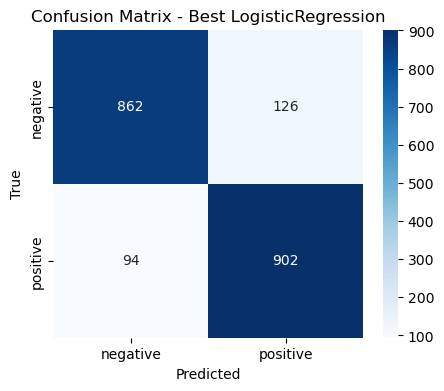

ML test ROC AUC: 0.9539006227338505


In [76]:
import joblib
import os
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# The y_test_ml and train_df are defined in previous cells
y_test = y_test_ml

# Assuming the original dataframe 'df' or 'train_df' has the 'sentiment' column
# Create a LabelEncoder and fit it to all possible labels
le = LabelEncoder()
le.fit(train_df['sentiment'].unique())

n_classes = len(le.classes_)

OUT_DIR = "../saved_data"

best_tfidf = joblib.load(os.path.join(OUT_DIR,"models","best_tfidf.joblib"))
best_clf = joblib.load(os.path.join(OUT_DIR,"models","best_logreg.joblib"))

X_test_tfidf = best_tfidf.transform(test_df['text_tfidf'])
yhat_test = best_clf.predict(X_test_tfidf)
probs_test = best_clf.predict_proba(X_test_tfidf)[:,1] if n_classes==2 else best_clf.predict_proba(X_test_tfidf)
print("Best ML Test classification report:")
print(classification_report(y_test, yhat_test, target_names=le.classes_))

cm = confusion_matrix(y_test, yhat_test)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix - Best LogisticRegression")
plt.xlabel("Predicted"); plt.ylabel("True")
# Create the directory if it doesn't exist
os.makedirs(os.path.join(OUT_DIR, "figures"), exist_ok=True)
plt.savefig(os.path.join(OUT_DIR,"figures","cm_ml.png"), bbox_inches='tight')
plt.show()

if n_classes==2:
    print("ML test ROC AUC:", roc_auc_score(y_test, probs_test))

6. Preparing Deep Learning inputs

In [77]:
MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 300

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(train_df['enhanced_clean']), maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_val_seq   = pad_sequences(tokenizer.texts_to_sequences(val_df['enhanced_clean']), maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_seq  = pad_sequences(tokenizer.texts_to_sequences(test_df['enhanced_clean']), maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

vocab_size = min(MAX_VOCAB_SIZE, len(tokenizer.word_index) + 1)
print("Tokenizer built. vocab_size:", vocab_size, "seq shape:", X_train_seq.shape)

# Attempt to load GloVe from working dir or download
GLOVE_NAME = "glove.6B.100d.txt"
if not os.path.exists(GLOVE_NAME):
    print("Downloading GloVe (this may take a minute)...")
    # download and extract
    !wget -q -nc http://nlp.stanford.edu/data/glove.6B.zip
    !unzip -o glove.6B.zip glove.6B.100d.txt
print("GloVe present. Building embedding matrix...")

EMBED_DIM = 100
emb_index = {}
with open(GLOVE_NAME, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        emb_index[word] = coefs

embedding_matrix = np.zeros((vocab_size, EMBED_DIM))
for word, i in tokenizer.word_index.items():
    if i >= vocab_size:
        continue
    vec = emb_index.get(word)
    if vec is not None:
        embedding_matrix[i] = vec

coverage = np.sum(np.any(embedding_matrix, axis=1)) / vocab_size
print(f"Built embedding matrix. Coverage: {coverage:.2%}")
# Save tokenizer and embedding matrix for reuse
joblib.dump(tokenizer, os.path.join(OUT_DIR,"models","tokenizer.joblib"))
np.save(os.path.join(OUT_DIR,"models","embedding_matrix.npy"), embedding_matrix)


Tokenizer built. vocab_size: 20000 seq shape: (6941, 300)
GloVe present. Building embedding matrix...
Built embedding matrix. Coverage: 97.98%


7. Deep learning model builder (Bi-directional) and experiments

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support, log_loss

# Load variables from previous cells or saved files
try:
    y_train = y_train_ml
    y_val = y_val_ml
    y_test = y_test_ml
    X_train_seq = X_train_padded
    X_val_seq = X_val_padded
    X_test_seq = X_test_padded
    embedding_matrix = embedding_matrix

    # Check if tokenizer is available, otherwise load it
    if 'tokenizer' not in locals() and 'tokenizer' not in globals():
        OUT_DIR = "./output_experiments"
        tokenizer = joblib.load(os.path.join(OUT_DIR, 'tokenizer.pkl'))
    vocab_size = min(MAX_VOCAB_SIZE, len(tokenizer.word_index) + 1) # Assuming MAX_VOCAB_SIZE and tokenizer are available
    EMBED_DIM = embedding_matrix.shape[1] if embedding_matrix is not None else 100 # Assuming EMBED_DIM is defined or can be inferred
    n_classes = 2 # Assuming binary classification, adjust if needed based on y_train

except NameError:
    print("One or more required variables not found. Attempting to load from files...")
    try:
        OUT_DIR = "./output_experiments"
        y_train = np.load(os.path.join(OUT_DIR, 'y_train_ml.npy'))
        y_val = np.load(os.path.join(OUT_DIR, 'y_val_ml.npy'))
        y_test = np.load(os.path.join(OUT_DIR, 'y_test_ml.npy'))
        X_train_seq = np.load(os.path.join(OUT_DIR, 'X_train_padded.npy'))
        X_val_seq = np.load(os.path.join(OUT_DIR, 'X_val_padded.npy'))
        X_test_seq = np.load(os.path.join(OUT_DIR, 'X_test_padded.npy'))
        embedding_matrix = np.load(os.path.join(OUT_DIR, 'embedding_matrix.npy'))
        tokenizer = joblib.load(os.path.join(OUT_DIR, 'tokenizer.pkl'))
        MAX_VOCAB_SIZE = 20000 # Assuming this constant
        MAX_SEQUENCE_LENGTH = X_train_seq.shape[1]
        vocab_size = min(MAX_VOCAB_SIZE, len(tokenizer.word_index) + 1)
        EMBED_DIM = embedding_matrix.shape[1]
        n_classes = len(np.unique(y_train)) # Infer n_classes from data
        print("Variables loaded from files.")
    except FileNotFoundError:
        print("Required files not found. Please run previous cells to generate data.")
        # Exit or handle the error appropriately
        raise # Re-raise the error if files are essential

# Ensure tokenizer is loaded if not already available
if 'tokenizer' not in locals() and 'tokenizer' not in globals():
    OUT_DIR = "./output_experiments"
    tokenizer = joblib.load(os.path.join(OUT_DIR, 'tokenizer.pkl'))


def build_bilstm(vocab_size, maxlen, embedding_dim=100, embedding_matrix=None, trainable_embedding=False, lstm_units=128, dropout_rate=0.5, n_classes=2):
    inp = Input(shape=(maxlen,))
    if embedding_matrix is not None:
        # Ensure embedding_matrix has the correct shape
        if embedding_matrix.shape[0] != vocab_size or embedding_matrix.shape[1] != embedding_dim:
            print(f"Warning: Embedding matrix shape mismatch. Expected ({vocab_size}, {embedding_dim}), got {embedding_matrix.shape}. Using default embedding initialization.")
            emb = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen, trainable=trainable_embedding)(inp)
        else:
             emb = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=trainable_embedding)(inp)
    else:
        emb = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen)(inp)

    x = Bidirectional(LSTM(lstm_units))(emb)
    x = Dropout(dropout_rate)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)

    if n_classes == 2:
        out = Dense(1, activation='sigmoid')(x)
        model = Model(inputs=inp, outputs=out)
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
    else:
        out = Dense(n_classes, activation='softmax')(x)
        model = Model(inputs=inp, outputs=out)
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
    return model

# Define experiments
dl_exps = [
    {"id":"DL-A", "embedding_matrix": None, "emb_dim":EMBED_DIM, "trainable":True, "lstm_units":128, "batch":64, "lr":1e-3, "dropout":0.5, "notes":"Random embeddings baseline"},
    {"id":"DL-B", "embedding_matrix": embedding_matrix, "emb_dim":EMBED_DIM, "trainable":False, "lstm_units":128, "batch":64, "lr":5e-4, "dropout":0.5, "notes":"GloVe frozen"},
    {"id":"DL-C", "embedding_matrix": embedding_matrix, "emb_dim":EMBED_DIM, "trainable":True, "lstm_units":256, "batch":32, "lr":1e-4, "dropout":0.3, "notes":"GloVe fine-tune larger LSTM"},
]

dl_results = []
for exp in dl_exps:
    print("\nRunning", exp['id'], exp['notes'])
    if exp['embedding_matrix'] is None:
        emb_mat = None
    else:
        emb_mat = exp['embedding_matrix']

    model = build_bilstm(vocab_size=vocab_size, maxlen=MAX_SEQUENCE_LENGTH, embedding_dim=exp['emb_dim'],
                        embedding_matrix=emb_mat, trainable_embedding=exp['trainable'], lstm_units=exp['lstm_units'],
                        dropout_rate=exp['dropout'], n_classes=n_classes)

    # set optimizer lr (fix)
    model.optimizer.learning_rate = float(exp['lr'])


    print(model.summary())

    # callbacks
    ckpt = os.path.join(OUT_DIR,"models", f"{exp['id']}_best.h5")
    callbacks = [EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
                 ModelCheckpoint(ckpt, monitor='val_loss', save_best_only=True, verbose=0),
                 ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=0)]

    # prepare Y
    if n_classes==2:
        ytr = np.array(y_train)
        yv = np.array(y_val)
    else:
        ytr = tf.keras.utils.to_categorical(y_train, num_classes=n_classes)
        yv = tf.keras.utils.to_categorical(y_val, num_classes=n_classes)


    hist = model.fit(X_train_seq, ytr, validation_data=(X_val_seq, yv), epochs=10, batch_size=exp['batch'], callbacks=callbacks, verbose=1)

    # eval on val
    if n_classes==2:
        val_probs = model.predict(X_val_seq).ravel()
        val_preds = (val_probs >= 0.5).astype(int)
    else:
        val_probs = model.predict(X_val_seq)
        val_preds = np.argmax(val_probs, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(y_val, val_preds, average='macro', zero_division=0)
    acc = (val_preds == y_val).mean()
    ll = log_loss(y_val, val_probs)

    dl_results.append({
        "exp_id": exp['id'],
        "notes": exp['notes'],
        "trainable_embedding": exp['trainable'],
        "lstm_units": exp['lstm_units'],
        "batch": exp['batch'],
        "lr": exp['lr'],
        "val_accuracy": acc,
        "val_f1_macro": f1,
        "val_logloss": ll,
        "best_epoch": len(hist.history['loss']) - 1
    })

    # save history and loss plot
    os.makedirs(os.path.join(OUT_DIR,"figures"), exist_ok=True)
    pd.DataFrame(hist.history).to_csv(os.path.join(OUT_DIR,"figures", f"{exp['id']}_history.csv"), index=False)
    plt.figure(figsize=(6,4))
    plt.plot(hist.history['loss'], label='train_loss')
    plt.plot(hist.history['val_loss'], label='val_loss')
    plt.title(f"Loss - {exp['id']}")
    plt.legend(); plt.savefig(os.path.join(OUT_DIR,"figures", f"{exp['id']}_loss.png"), bbox_inches='tight'); plt.close()

    os.makedirs(os.path.join(OUT_DIR,"models"), exist_ok=True)
    model.save(os.path.join(OUT_DIR,"models", f"{exp['id']}_final.h5"))
    print("Saved DL model", exp['id'])


dl_df = pd.DataFrame(dl_results).sort_values("val_f1_macro", ascending=False).reset_index(drop=True)
dl_df.to_csv(os.path.join("../saved_data/output_experiments","experiments_dl.csv"), index=False)
display(dl_df)


Running DL-A Random embeddings baseline


/home/lscblack/miniconda3/envs/ml-gpu/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
W0000 00:00:1759399336.303792   14733 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 300, 100)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,251,009 (8.59 MB)

 Trainable params: 2,251,009 (8.59 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.5360 - loss: 0.6842

109/109 ━━━━━━━━━━━━━━━━━━━━ 55s 472ms/step - accuracy: 0.5916 - loss: 0.6590 - val_accuracy: 0.7550 - val_loss: 0.5841 - learning_rate: 0.0010
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.8300 - loss: 0.4349

109/109 ━━━━━━━━━━━━━━━━━━━━ 47s 430ms/step - accuracy: 0.8275 - loss: 0.4166 - val_accuracy: 0.8246 - val_loss: 0.4066 - learning_rate: 0.0010
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 44s 405ms/step - accuracy: 0.9226 - loss: 0.2192 - val_accuracy: 0.8165 - val_loss: 0.4282 - learning_rate: 0.0010
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 45s 410ms/step - accuracy: 0.9576 - loss: 0.1321 - val_accuracy: 0.8266 - val_loss: 0.4990 - learning_rate: 0.0010
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 46s 419ms/step - accuracy: 0.9850 - loss: 0.0534 - val_accuracy: 0.8256 - val_loss: 0.6197 - learning_rate: 5.0000e-04
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 46s 418ms/step - accuracy: 0.9939 - loss: 0.0259 - val_accuracy: 0.8155 - val_loss: 0.8496 - learning_rate: 5.0000e-04
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step


Saved DL model DL-A

Running DL-B GloVe frozen


/home/lscblack/miniconda3/envs/ml-gpu/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 300, 100)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,251,009 (8.59 MB)

 Trainable params: 251,009 (980.50 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

None
Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.5258 - loss: 0.6937

109/109 ━━━━━━━━━━━━━━━━━━━━ 45s 390ms/step - accuracy: 0.5554 - loss: 0.6823 - val_accuracy: 0.5181 - val_loss: 0.8467 - learning_rate: 5.0000e-04
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.5239 - loss: 0.7231

109/109 ━━━━━━━━━━━━━━━━━━━━ 42s 388ms/step - accuracy: 0.5348 - loss: 0.6997 - val_accuracy: 0.5917 - val_loss: 0.6707 - learning_rate: 5.0000e-04
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 42s 390ms/step - accuracy: 0.6084 - loss: 0.6638 - val_accuracy: 0.5363 - val_loss: 0.6855 - learning_rate: 5.0000e-04
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.5875 - loss: 0.6711

109/109 ━━━━━━━━━━━━━━━━━━━━ 35s 323ms/step - accuracy: 0.6112 - loss: 0.6610 - val_accuracy: 0.6915 - val_loss: 0.6162 - learning_rate: 5.0000e-04
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 187ms/step - accuracy: 0.5916 - loss: 0.6740 - val_accuracy: 0.6280 - val_loss: 0.6459 - learning_rate: 5.0000e-04
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 187ms/step - accuracy: 0.5895 - loss: 0.6634 - val_accuracy: 0.5948 - val_loss: 0.6764 - learning_rate: 5.0000e-04
Epoch 7/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 187ms/step - accuracy: 0.5934 - loss: 0.6694 - val_accuracy: 0.5958 - val_loss: 0.6667 - learning_rate: 2.5000e-04
Epoch 8/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.6321 - loss: 0.6466

109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 183ms/step - accuracy: 0.6381 - loss: 0.6440 - val_accuracy: 0.6895 - val_loss: 0.6070 - learning_rate: 2.5000e-04
Epoch 9/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.7197 - loss: 0.5839

109/109 ━━━━━━━━━━━━━━━━━━━━ 21s 192ms/step - accuracy: 0.7198 - loss: 0.5791 - val_accuracy: 0.6845 - val_loss: 0.5848 - learning_rate: 2.5000e-04
Epoch 10/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.7153 - loss: 0.5882

109/109 ━━━━━━━━━━━━━━━━━━━━ 22s 202ms/step - accuracy: 0.7231 - loss: 0.5727 - val_accuracy: 0.7268 - val_loss: 0.5329 - learning_rate: 2.5000e-04
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step


Saved DL model DL-B

Running DL-C GloVe fine-tune larger LSTM


/home/lscblack/miniconda3/envs/ml-gpu/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 300, 100)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 512)            │       731,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,764,033 (10.54 MB)

 Trainable params: 2,764,033 (10.54 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.5144 - loss: 0.6936

217/217 ━━━━━━━━━━━━━━━━━━━━ 95s 429ms/step - accuracy: 0.5541 - loss: 0.6822 - val_accuracy: 0.5655 - val_loss: 0.6877 - learning_rate: 1.0000e-04
Epoch 2/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.6303 - loss: 0.6419

217/217 ━━━━━━━━━━━━━━━━━━━━ 83s 383ms/step - accuracy: 0.6745 - loss: 0.6093 - val_accuracy: 0.7540 - val_loss: 0.5200 - learning_rate: 1.0000e-04
Epoch 3/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 93s 430ms/step - accuracy: 0.7476 - loss: 0.5295 - val_accuracy: 0.7107 - val_loss: 0.5509 - learning_rate: 1.0000e-04
Epoch 4/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.7651 - loss: 0.5065

217/217 ━━━━━━━━━━━━━━━━━━━━ 95s 439ms/step - accuracy: 0.7764 - loss: 0.4946 - val_accuracy: 0.7913 - val_loss: 0.4799 - learning_rate: 1.0000e-04
Epoch 5/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 96s 442ms/step - accuracy: 0.8103 - loss: 0.4410 - val_accuracy: 0.7651 - val_loss: 0.5257 - learning_rate: 1.0000e-04
Epoch 6/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.8206 - loss: 0.4147

217/217 ━━━━━━━━━━━━━━━━━━━━ 93s 427ms/step - accuracy: 0.8218 - loss: 0.4155 - val_accuracy: 0.8095 - val_loss: 0.4090 - learning_rate: 1.0000e-04
Epoch 7/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 98s 451ms/step - accuracy: 0.8425 - loss: 0.3883 - val_accuracy: 0.7823 - val_loss: 0.4991 - learning_rate: 1.0000e-04
Epoch 8/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 94s 433ms/step - accuracy: 0.8551 - loss: 0.3575 - val_accuracy: 0.7933 - val_loss: 0.4374 - learning_rate: 1.0000e-04
Epoch 9/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.8745 - loss: 0.3267

217/217 ━━━━━━━━━━━━━━━━━━━━ 99s 457ms/step - accuracy: 0.8781 - loss: 0.3150 - val_accuracy: 0.8145 - val_loss: 0.3917 - learning_rate: 5.0000e-05
Epoch 10/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 93s 427ms/step - accuracy: 0.8810 - loss: 0.3007 - val_accuracy: 0.8145 - val_loss: 0.4316 - learning_rate: 5.0000e-05
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step


Saved DL model DL-C


,exp_id,notes,trainable_embedding,lstm_units,batch,lr,val_accuracy,val_f1_macro,val_logloss,best_epoch
0,DL-A,Random embeddings baseline,True,128,64,0.0010,0.824597,0.824539,0.406634,5
1,DL-C,GloVe fine-tune larger LSTM,True,256,32,0.0001,0.814516,0.814441,0.391651,9
2,DL-B,GloVe frozen,False,128,64,0.0005,0.726815,0.724697,0.532853,9


8. Final evalution: Best Machine Learning and Deep Learning model on test set

Best ML config: {'model': 'LogisticRegression', 'tfidf_cfg': 'bigrams_30k', 'max_features': 30000, 'ngram_range': '(1, 2)', 'C': 1.0, 'class_weight': nan, 'val_accuracy': 0.875, 'val_f1_macro': 0.8748697916666667, 'val_precision_macro': 0.8762545080696487, 'val_recall_macro': 0.8748841519925857, 'val_logloss': 0.3982505473336641}
ML Test report:
              precision    recall  f1-score   support

    negative       0.90      0.87      0.89       988
    positive       0.88      0.91      0.89       996

    accuracy                           0.89      1984
   macro avg       0.89      0.89      0.89      1984
weighted avg       0.89      0.89      0.89      1984



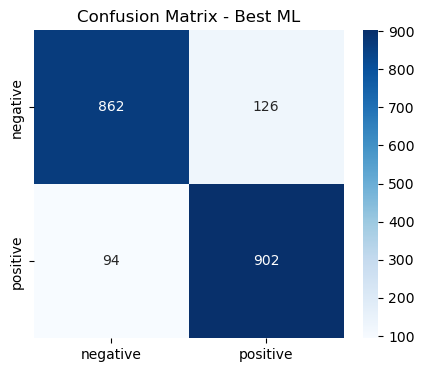

Best DL: {'exp_id': 'DL-A', 'notes': 'Random embeddings baseline', 'trainable_embedding': True, 'lstm_units': 128, 'batch': 64, 'lr': 0.001, 'val_accuracy': 0.8245967741935484, 'val_f1_macro': 0.8245390042084291, 'val_logloss': 0.4066343140769944, 'best_epoch': 5}


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step
DL Test report:
              precision    recall  f1-score   support

    negative       0.83      0.86      0.84       988
    positive       0.86      0.82      0.84       996

    accuracy                           0.84      1984
   macro avg       0.84      0.84      0.84      1984
weighted avg       0.84      0.84      0.84      1984



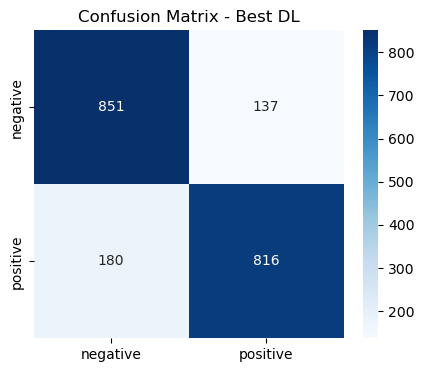

In [85]:
import pandas as pd
import os
import joblib
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Assuming y_test_ml, train_df, test_df, X_test_padded are defined in previous cells
y_test = y_test_ml
le = LabelEncoder()
le.fit(train_df['sentiment'].unique())
n_classes = len(le.classes_)
X_test_seq = X_test_padded


# Best ML
OUT_DIR = "../saved_data/output_experiments"

ml_df = pd.read_csv(os.path.join(OUT_DIR,"experiments_ml.csv"))
best_ml_row = ml_df.iloc[0]
print("Best ML config:", best_ml_row.to_dict())
best_tfidf = joblib.load(os.path.join("../saved_data","models","best_tfidf.joblib"))
best_clf = joblib.load(os.path.join("../saved_data","models","best_logreg.joblib"))
X_test_tfidf = best_tfidf.transform(test_df['text_tfidf'])
yhat_ml = best_clf.predict(X_test_tfidf)
print("ML Test report:")
print(classification_report(y_test, yhat_ml, target_names=le.classes_))

cm = confusion_matrix(y_test, yhat_ml)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix - Best ML"); plt.savefig(os.path.join("../saved_data","figures","cm_best_ml.png"), bbox_inches='tight')
plt.show()

# Best DL
dl_df = pd.read_csv(os.path.join("../saved_data/output_experiments","experiments_dl.csv"))
best_dl = dl_df.iloc[0]
best_dl_id = best_dl['exp_id']
print("Best DL:", best_dl.to_dict())
dl_model = tf.keras.models.load_model(os.path.join("../saved_data","models", f"{best_dl_id}_final.h5"))
if n_classes==2:
    probs_dl = dl_model.predict(X_test_seq).ravel()
    preds_dl = (probs_dl >= 0.5).astype(int)
else:
    probs_dl = dl_model.predict(X_test_seq)
    preds_dl = np.argmax(probs_dl, axis=1)

print("DL Test report:")
print(classification_report(y_test, preds_dl, target_names=le.classes_))
cm = confusion_matrix(y_test, preds_dl)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix - Best DL"); plt.savefig(os.path.join("../saved_data","figures","cm_best_dl.png"), bbox_inches='tight')
plt.show()

9. Save summaries and experiment tables for report

In [91]:
import json

# Save ML and DL CSVs already written
summary = {
    "best_ml": best_ml_row.to_dict(),
    "best_dl": best_dl.to_dict()
}
OUT_DIR = "../saved_data"
with open(os.path.join(OUT_DIR,"summary.json"), "w") as f:
    json.dump(summary, f, indent=2)

print("All experiments & artifacts saved to", OUT_DIR)
!ls -la "../saved_data"

All experiments & artifacts saved to ../saved_data
total 36
drwxrwxr-x 8 lscblack lscblack 4096 Oct  2 12:34 .
drwxrwxr-x 6 lscblack lscblack 4096 Oct  2 11:52 ..
drwxrwxr-x 2 lscblack lscblack 4096 Oct  2 11:53 data_splits
drwxrwxr-x 2 lscblack lscblack 4096 Oct  2 11:52 figs
drwxrwxr-x 2 lscblack lscblack 4096 Oct  2 12:32 figures
drwxrwxr-x 2 lscblack lscblack 4096 Oct  2 12:27 models
drwxrwxr-x 2 lscblack lscblack 4096 Oct  2 12:32 output_experiments
drwxrwxr-x 2 lscblack lscblack 4096 Oct  2 11:58 scaled_data
-rw-rw-r-- 1 lscblack lscblack  694 Oct  2 12:34 summary.json
